In [128]:
from pycocotools.coco import COCO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [129]:
def get_person_annotations(img_id, coco):
    """
    Get all annotations of Person objects for a given image
    
    Args:
        img_id: COCO dataset image ID
        coco: COCO API instance
    
    Returns:
        Person objects annotations dictionaries list
    """
    person_cat_id = 1
    
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=[person_cat_id])
    annotations = coco.loadAnns(ann_ids)
    
    return annotations

In [130]:
def process_coco_dataset(annotation_file):
    """
    Processes whole COCO dataset and extracts all Person type annotations.
    
    Args:
        annotation_file: COCO annotations file path
        
    Returns:
        Dictionary with img_id as key and annotations list as value
    """
    coco = COCO(annotation_file)
    
    img_ids = coco.getImgIds()
    
    results = {}
    
    for img_id in img_ids:
        person_annotations = get_person_annotations(img_id, coco)
        if person_annotations: 
            results[img_id] = {
                'image_info': coco.loadImgs(img_id)[0],
                'annotations': person_annotations
            }
    
    return results

In [131]:
def extract_person_details(annotations):
    """
    Extracts detailed informations about people from annotations.
    
    Args:
        annotations: annotations dictionary for an image
        
    Returns:
        List of dictionaries with details for each person
    """
    people = []
    for ann in annotations['annotations']:
        person = {
            'bbox': ann['bbox'],  # [x,y,width,height]
            'area': ann['area'],
            'segmentation': ann['segmentation'],
            'keypoints': ann.get('keypoints', None),
            'num_keypoints': ann.get('num_keypoints', None),
        }
        people.append(person)
    
    return people

In [132]:
img_width = 640
img_height = 480
img_size = img_width * img_height
annotation_file = 'person_keypoints_train2017.json'

results = process_coco_dataset(annotation_file)
number_people = {}
single_person = {}

for img_id, data in results.items():
    people = extract_person_details(data)
    number_people[img_id] = len(people)
    for i, person in enumerate(people, 1):
        single_person[f"{img_id}{i}"] = {'ID': f'{img_id}{i}', 'Img': img_id, 'person_num': i, 'num_people': len(people), 'bbox': person['bbox'], 'area': person['area'], 'keypoints': person['keypoints'], 'num_keypoints': person['num_keypoints']}

loading annotations into memory...
Done (t=5.69s)
creating index...
index created!


In [133]:
df = pd.DataFrame.from_dict(single_person, orient='index')
df = df.set_index('ID')

In [134]:
df['x'] = df['bbox'].apply(lambda x: x[0])
df['y'] = df['bbox'].apply(lambda x: x[1])
df['width'] = df['bbox'].apply(lambda x: x[2])
df['height'] = df['bbox'].apply(lambda x: x[3])
df = df.drop(['bbox'], axis=1)


In [135]:
df['area_norm'] = df['area']/img_size

In [136]:
keypoints_body_parts = ["nose", "left_eye", "right_eye", "left_ear", "right_ear", "left_shoulder", "right_shoulder", 
                        "left_elbow", "right_elbow", "left_wrist", "right_wrist", "left_hip", "right_hip", 
                        "left_knee", "right_knee", "left_ankle", "right_ankle"]

In [137]:
for index, body_part in enumerate(keypoints_body_parts):
    df[f"{body_part}_x"] = df['keypoints'].apply(lambda x: x[index * 3])
    df[f"{body_part}_y"] = df['keypoints'].apply(lambda x: x[index * 3+1])
    df[f"{body_part}_v"] = df['keypoints'].apply(lambda x: x[index * 3+2])

## num_people_diff

In [200]:
def num_people_diff(num_people: int):
    return 1-(1/(num_people+1))

In [201]:
def add_num_people_diff(df):
    df['num_people_diff'] = df['num_people'].apply(num_people_diff)

In [202]:
def create_grouped_df(df):
    return df[['Img', 'num_people', 'area_norm']].groupby('Img').agg({
    'area_norm': 'sum',  
    'num_people': 'count'
})

In [218]:
def create_df(col_name, col_dimension_name, param_num, dimension):
    return df[(df[col_name]+df[col_dimension_name])<=(param_num*dimension)]

In [219]:
img_df = df[['Img', 'num_people', 'area_norm']].groupby('Img').agg({
    'area_norm': 'sum',  
    'num_people': 'count'
})
img_df['num_people_diff'] = img_df['num_people'].apply(num_people_diff)

#### top 75

In [220]:
top_75_df = create_grouped_df(create_df('y', 'height', 0.75, img_height))
add_num_people_diff(top_75_df)

#### top 25

In [221]:
top_25_df = create_grouped_df(create_df('y', 'height', 0.25, img_height))
add_num_people_diff(top_25_df)

#### top 50

In [223]:
top_50_df = create_grouped_df(create_df('y', 'height', 0.5, img_height))
add_num_people_diff(top_50_df)

#### side 25

In [225]:
side_25_df = create_grouped_df(create_df('x', 'width', 0.25, img_height))
add_num_people_diff(side_25_df)

#### side 50

In [227]:
side_50_df = create_grouped_df(create_df('x', 'width', 0.5, img_width))
add_num_people_diff(side_50_df)

#### side 75

In [229]:
side_75_df = create_grouped_df(create_df('x', 'width', 0.75, img_width))
add_num_people_diff(side_75_df)

In [230]:
df_list = [img_df, top_25_df, top_50_df, top_75_df, side_25_df, side_50_df, side_75_df]
df_names = ['All', 'Top 25', 'Top 50', 'Top 75', 'Side 25', 'Side 50', 'Side 75']

In [231]:
def plot_hist(df, title):
    plt.bar(df['num_people_diff'].value_counts().keys(), df['num_people_diff'].value_counts().values, width=0.005, color="skyblue", edgecolor="black")
    plt.xlabel("num_people_diff")
    plt.ylabel("Count")
    plt.title(f"{title}")
    plt.grid(axis="y", linestyle="--", alpha=0.7)

## Plot

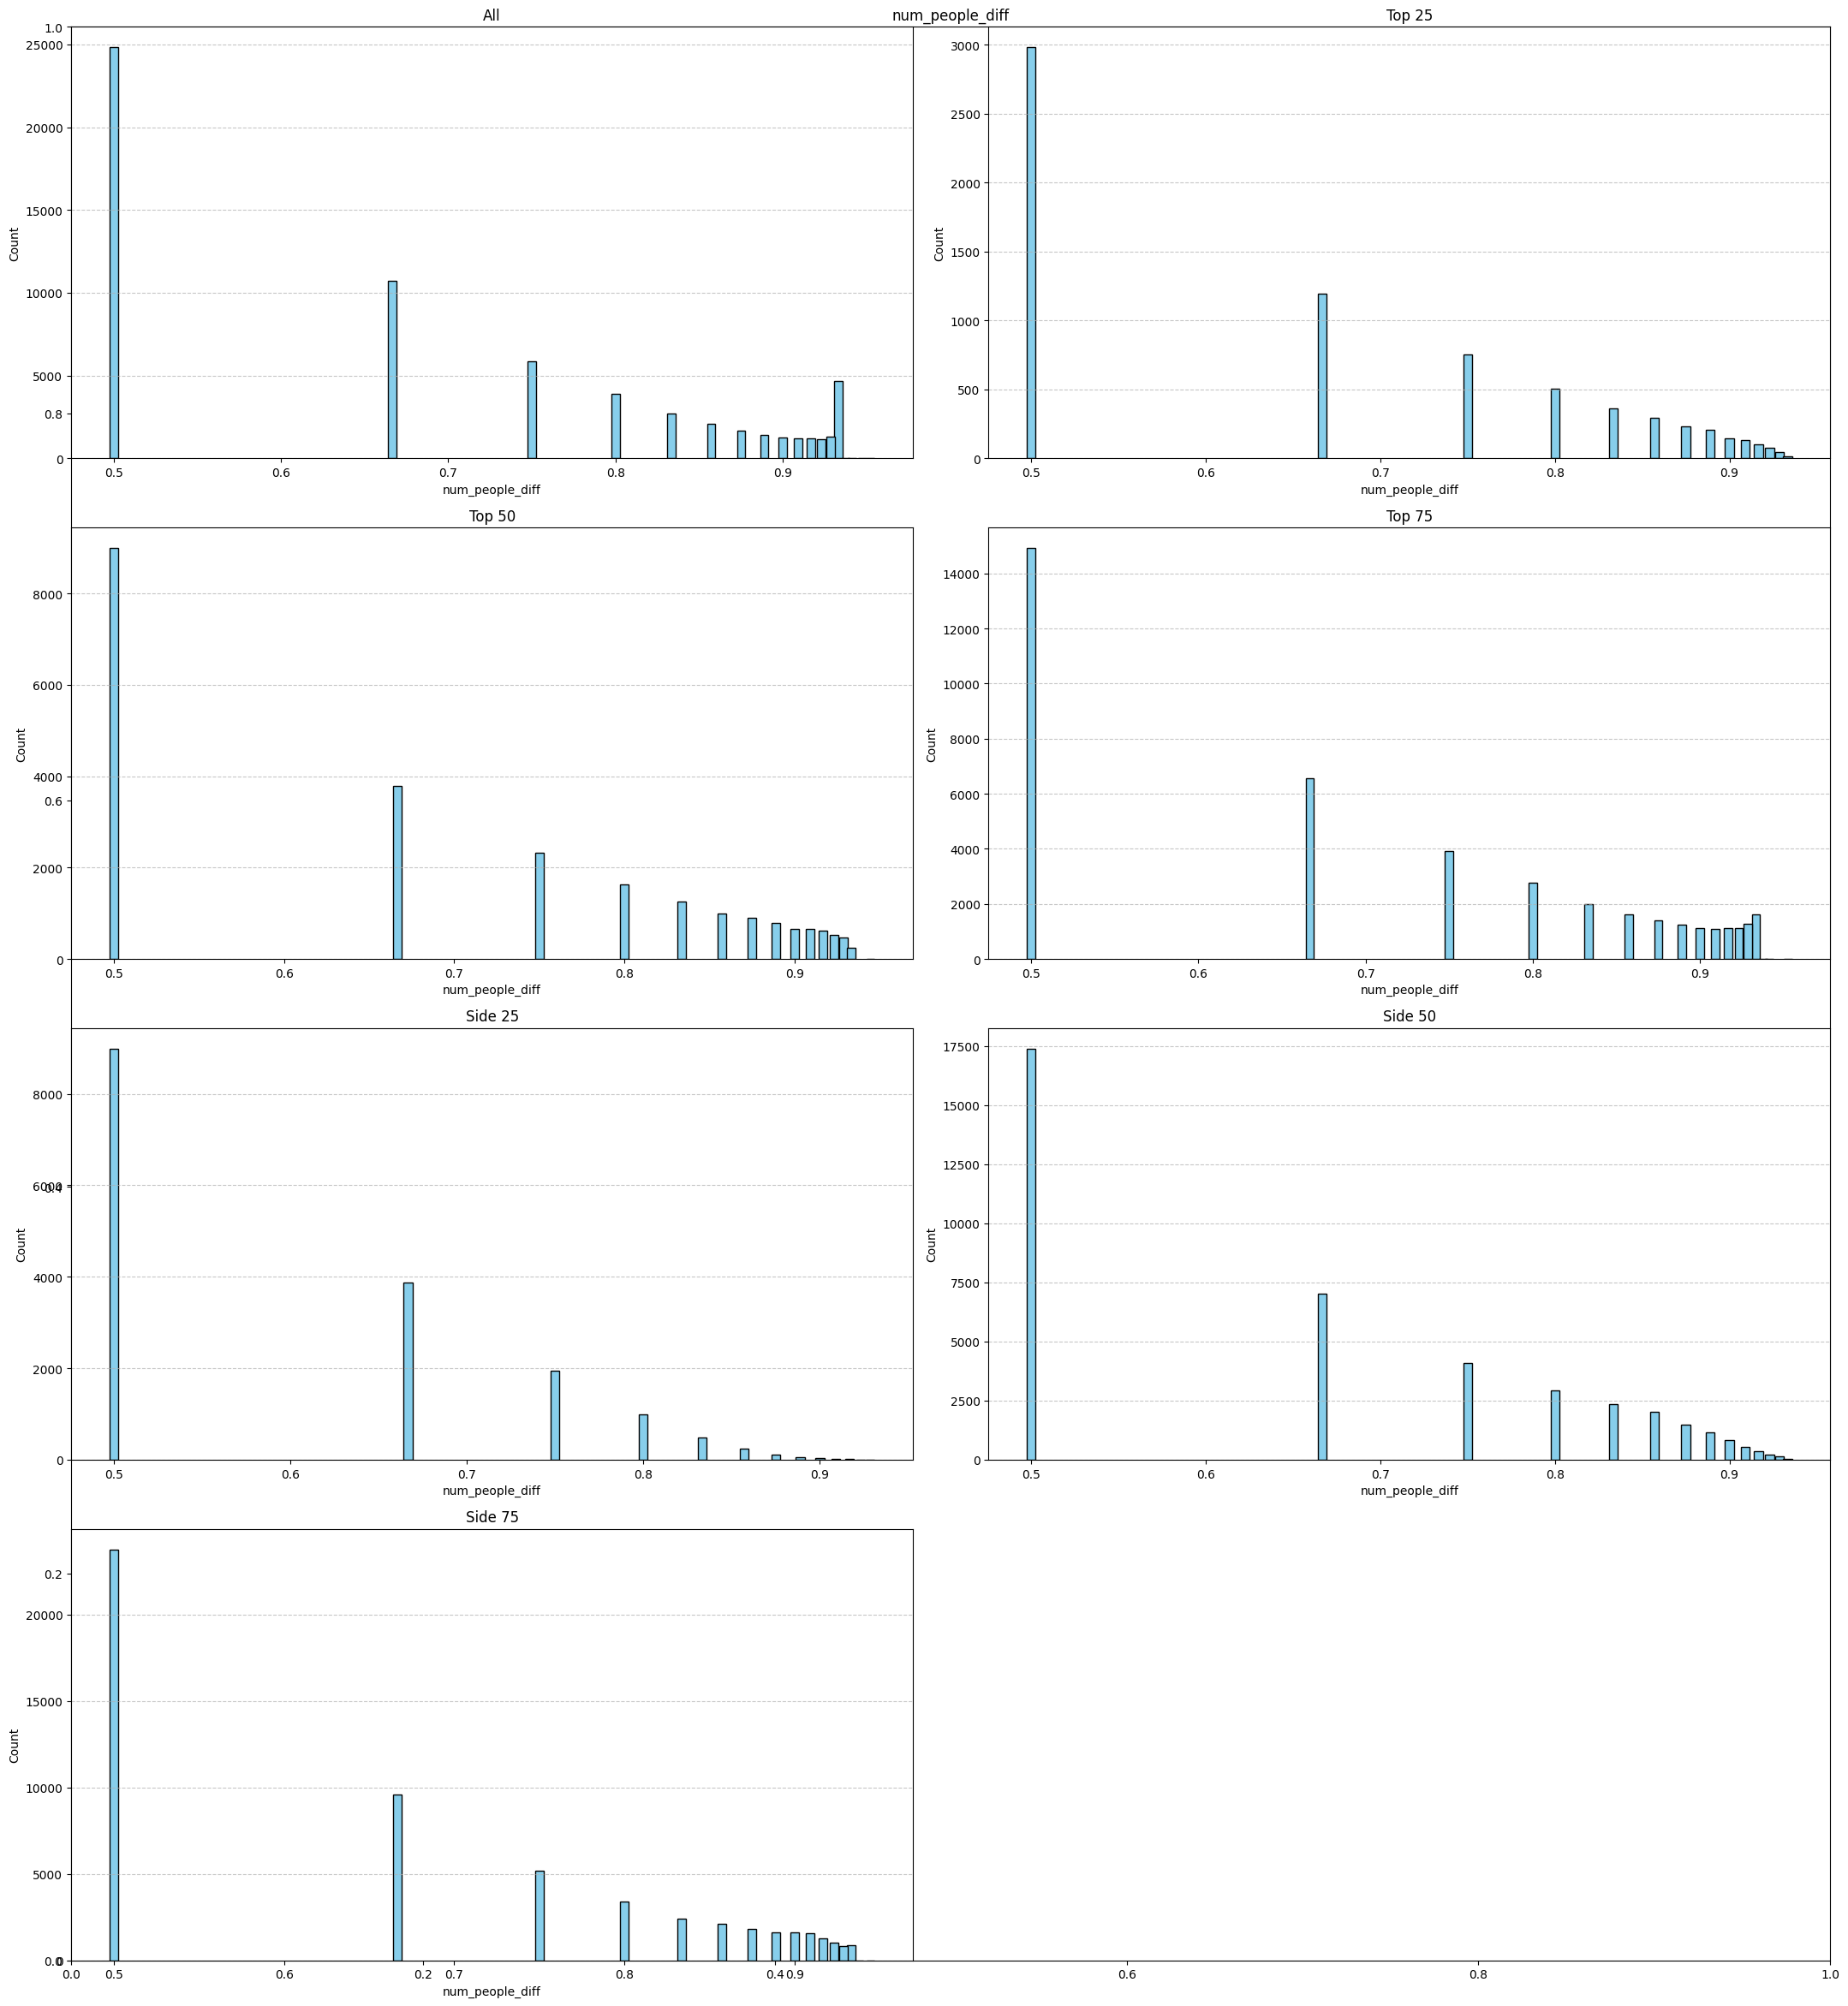

In [232]:
plt.figure(figsize=(22, 24))
plt.title(f"num_people_diff")
for index, data in enumerate(zip(df_names, df_list)):
    ax = plt.subplot(4, 2, index+1)
    plot_hist(data[1], data[0])
    
plt.tight_layout()

plt.show()

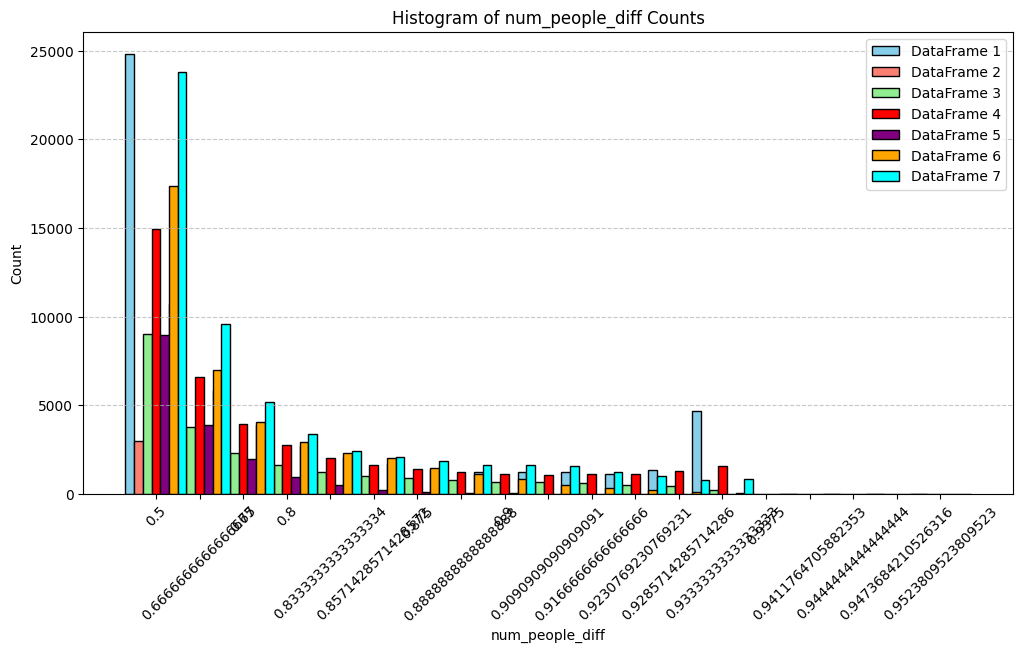

In [233]:
dataframes = [img_df, top_25_df, top_50_df, top_75_df, side_25_df, side_50_df, side_75_df]
colors = ["skyblue", "salmon", "lightgreen", "red", "purple", "orange", "cyan"]

# Calculate unique x-axis labels and their positions
unique_keys = sorted(set().union(*(df_temp['num_people_diff'].unique() for df_temp in dataframes)))
bar_width = 0.2  
x_positions = np.arange(len(unique_keys))  # Base x-positions for each unique key

plt.figure(figsize=(12, 6))

for i, (df_temp, color) in enumerate(zip(dataframes, colors)):
    counts = df_temp['num_people_diff'].value_counts()
    values = [counts.get(key, 0) for key in unique_keys]
    
    offset = (i - (len(dataframes) - 1) / 2) * bar_width
    plt.bar(x_positions + offset, values, width=bar_width, color=color, edgecolor="black", label=f"DataFrame {i+1}")

plt.xlabel("num_people_diff")
plt.ylabel("Count")
plt.title("Histogram of num_people_diff Counts")
plt.xticks(x_positions, unique_keys, rotation=45) 
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.show()


## people_size_dif

In [234]:
def 

SyntaxError: invalid syntax (1885169875.py, line 1)

In [ ]:
img_df['people_size_diff'] = np.maximum(0, 1-img_df['area_norm']/img_df['num_people'])

In [ ]:
top_25_df['people_size_diff'] = np.maximum(0, 1-top_25_df['area_norm']/top_25_df['num_people'])

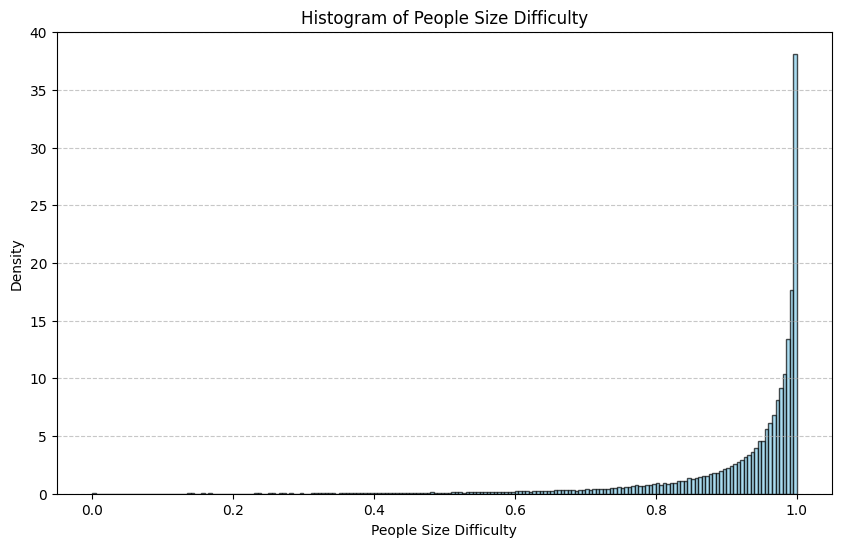

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(img_df['people_size_diff'], bins=200, color="skyblue", edgecolor="black", alpha=0.7, density=True)

# Aggiungi etichette e titolo
plt.xlabel("People Size Difficulty")
plt.ylabel("Density")
plt.title("Histogram of People Size Difficulty")

# Aggiungi una griglia
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Mostra l'istogramma
plt.show()